# This is a newer version of SincNet with updated Loading and training functions

In [1]:
import os
import librosa 
import librosa.display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import math

import sys

import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
## Local files imports:
from Models import MLP, flip, MainNet
from Models import SincNet as CNN 
from Models import SincNet2D as CNN2D
from utils import Optimizers, Schedulers, Dataset, plot_grad_flow, NLLL_OneHot, InitOptimizer, test_2D_raise_or_run
from read_conf_files import read_conf
from ipython_exit import exit

## Choosing Graphics Card

In [3]:
Desired_cuda_device_number = 0

print("Selecting Cuda device... \t\t", end="")
if torch.cuda.is_available(): # we'll use cuda
    device = "cuda:"+str(Desired_cuda_device_number)
    torch.cuda.set_device(device)
    if(torch.cuda.current_device() == Desired_cuda_device_number and torch.cuda.is_available()):
        print("Cuda was selected successfully!")
    else:
        print("Cuda was not selected successfully...")
else:
    print("Cuda device(s) is(are) not available.")

Selecting Cuda device... 		Cuda was selected successfully!


## Loading the Model

### Conf loader:

[Link to documentation](https://docs.python.org/3/library/configparser.html)

In [4]:
"""def read_conf(config_file_path):
    # Removed the possibility of executing with --cfg = path
    # Instead we feed it directly

    # Initializing dummy class with cfg folder path:
    options = Options(config_file_path)

    # Reading the config file with config parser
    Config = ConfigParser.ConfigParser()
    Config.read(options.cfg)

    #[data]
    options.tr_lst=Config.get('data', 'tr_lst')
    options.te_lst=Config.get('data', 'te_lst')
    options.lab_dict=Config.get('data', 'lab_dict')
    options.data_folder=Config.get('data', 'data_folder')
    options.output_folder=Config.get('data', 'output_folder')
    options.pt_file=Config.get('data', 'pt_file')

    #[windowing]
    options.fs=Config.get('windowing', 'fs')
    options.cw_len=Config.get('windowing', 'cw_len')
    options.cw_shift=Config.get('windowing', 'cw_shift')

    if('cnn2D' in Config.sections()):
        #[cnn2D]
        options.is_conv2D = True
        options.cnn_N_filt=Config.get('cnn2D', 'cnn_N_filt')
        options.cnn_len_filt_W=Config.get('cnn2D', 'cnn_len_filt_W')
        options.cnn_len_filt_H=Config.get('cnn2D', 'cnn_len_filt_H')
        options.cnn_energy_L=Config.get('cnn2D', 'cnn_energy_L')
        options.cnn_energy_stride=Config.get('cnn2D', 'cnn_energy_stride')
        options.cnn_max_pool_len_W=Config.get('cnn2D', 'cnn_max_pool_len_W')
        options.cnn_max_pool_len_H=Config.get('cnn2D', 'cnn_max_pool_len_H')
        options.cnn_use_laynorm_inp=Config.get('cnn2D', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn2D', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn2D', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn2D', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn2D', 'cnn_act')
        options.cnn_drop=Config.get('cnn2D', 'cnn_drop')
    else:
        #[cnn]
        options.is_conv2D = False
        options.cnn_N_filt=Config.get('cnn', 'cnn_N_filt')
        options.cnn_len_filt=Config.get('cnn', 'cnn_len_filt')
        options.cnn_max_pool_len=Config.get('cnn', 'cnn_max_pool_len')
        options.cnn_use_laynorm_inp=Config.get('cnn', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn', 'cnn_act')
        options.cnn_drop=Config.get('cnn', 'cnn_drop')


    #[dnn]
    options.fc_lay=Config.get('dnn', 'fc_lay')
    options.fc_drop=Config.get('dnn', 'fc_drop')
    options.fc_use_laynorm_inp=Config.get('dnn', 'fc_use_laynorm_inp')
    options.fc_use_batchnorm_inp=Config.get('dnn', 'fc_use_batchnorm_inp')
    options.fc_use_batchnorm=Config.get('dnn', 'fc_use_batchnorm')
    options.fc_use_laynorm=Config.get('dnn', 'fc_use_laynorm')
    options.fc_act=Config.get('dnn', 'fc_act')

    #[class]
    options.class_lay=Config.get('class', 'class_lay')
    options.class_drop=Config.get('class', 'class_drop')
    options.class_use_laynorm_inp=Config.get('class', 'class_use_laynorm_inp')
    options.class_use_batchnorm_inp=Config.get('class', 'class_use_batchnorm_inp')
    options.class_use_batchnorm=Config.get('class', 'class_use_batchnorm')
    options.class_use_laynorm=Config.get('class', 'class_use_laynorm')
    options.class_act=Config.get('class', 'class_act')

    #[optimization]
    if('optimization' in Config.sections()):
        if 'optimizer_type' in Config['optimization']:
            options.optimizer_type=Config.get('optimization', 'optimizer_type')
        else:
            options.optimizer_type='RMSprop'
            print("You did not specify the value of `optimizer_type`, it is set to {}.".format(options.optimizer_type))
        
        options.lr=Config.get('optimization', 'lr')

        ## use_scheduler:
        if 'use_scheduler' in Config['optimization']:
            options.use_scheduler=Config.get('optimization', 'use_scheduler')
        else:
            print("You did not specify the value of `use_scheduler`, it is set to False.")
            options.use_scheduler='False'

        ## scheduler_type:
        if 'scheduler_type' in Config['optimization']:
            options.scheduler_type=Config.get('optimization', 'scheduler_type')
        else:
            options.scheduler_type='ReduceLROnPlateau'
            print("You did not specify the value of `scheduler_type`, it is set to {}.".format(options.scheduler_type))    
        
        ## scheduler_patience:
        if 'scheduler_patience' in Config['optimization']:
            options.scheduler_patience=Config.get('optimization', 'scheduler_patience')
        else:
            options.scheduler_patience=2
            print("You did not specify the value of `scheduler_patience`, it is set to {}.".format(options.scheduler_patience))

        ## scheduler_factor:
        if 'scheduler_factor' in Config['optimization']:
            options.scheduler_factor=Config.get('optimization', 'scheduler_factor')
        else:
            options.scheduler_factor=0.5
            print("You did not specify the value of `scheduler_factor`, it is set to {}.".format(options.scheduler_factor))


        options.batch_size=Config.get('optimization', 'batch_size')

        ## Batch_dev:
        if 'Batch_dev' in Config['optimization']:
            options.Batch_dev=Config.get('optimization', 'Batch_dev')
        else:
            options.Batch_dev=32
            print("You did not specify the value of `Batch_dev`, it is set to {}.".format(options.Batch_dev))

        ## patience:
        if 'patience' in Config['optimization']:
            options.patience=Config.get('optimization', 'patience')
        else:
            print("You did not specify the value of `patience`, it is set to 7.")
            options.patience=7

        options.N_epochs=Config.get('optimization', 'N_epochs')
        options.N_batches=Config.get('optimization', 'N_batches')
        options.N_eval_epoch=Config.get('optimization', 'N_eval_epoch')
        
        ## train_acc_period:
        if 'train_acc_period' in Config['optimization']:
                options.train_acc_period=Config.get('optimization', 'train_acc_period')
        else:
            print("You did not specify the value of `train_acc_period`, it is set to 5.")
            options.train_acc_period=5
        
        ## fact_amp:        
        if 'fact_amp' in Config['optimization']:
                options.fact_amp=Config.get('optimization', 'fact_amp')
        else:
            options.fact_amp=0.2
            print("You did not specify the value of `fact_amp`, it is set to {}.".format(options.fact_amp))
        
        ## use_mixup:
        if 'use_mixup' in Config['optimization']:
            options.use_mixup=Config.get('optimization', 'use_mixup')
        else:
            print("You did not specify the value of `use_mixup`, it is set to False.")
            options.use_mixup='False'
        
        ## mixup_batch_prop:        
        if 'mixup_batch_prop' in Config['optimization']:
            options.mixup_batch_prop=Config.get('optimization', 'mixup_batch_prop')
        else:
            options.mixup_batch_prop=float(1.0) if options.use_mixup=='True' else float(0.0)
            print("You did not specify the value of `mixup_batch_prop`, it is set to {}%.".format(options.mixup_batch_prop*100))
        
        ## beta_coef:
        if 'beta_coef' in Config['optimization']:
            options.beta_coef=Config.get('optimization', 'beta_coef')
        else:
            print("You did not specify the value of `beta_coef`, it is set to 0.4.")
            options.beta_coef=0.4
        
        ## same_classes:        
        if 'same_classes' in Config['optimization']:
            options.same_classes=Config.get('optimization', 'same_classes')
        else:
            options.same_classes='False'
            print("You did not specify the value of `same_classes`, it is set to {}.".format(options.same_classes))
            if("True" in options.use_mixup):
                print("Warning: you are using mixup but you did not mention which type in config file. \n"+
                    "By default it will be set to False. You are advised to add a same_class attribute to your cfg file and set it to True or False.")    

            
        options.seed=Config.get('optimization', 'seed')
    else:
        print("Error, you did not specify optimization parameters in your cfg. Consequently, the code won't run...")
        
    #[Misc]
    ## In SincNet, we must always use SincConv_fast, it is the whole point of SincNet. But, just for testing, we added the possibility to deactivate it. 
    ## This is why we do not prompt the user if he does not have a `Misc`section.
    options.use_SincConv_fast='True'
    if('Misc' in Config.sections()):
        ## use_SincConv_fast:        
        if 'use_SincConv_fast' in Config['Misc']:
            options.use_SincConv_fast=Config.get('Misc', 'use_SincConv_fast')
        else:
            print("You did not specify the value of `use_SincConv_fast`, but don't worry, it is set to {}.".format(options.use_SincConv_fast))


    return options
"""

## read_conf is now imported from read_conf_files.py:
imported = "`read_conf` was successfully imported from read_conf_files.py!" if 'read_conf' in dir() else "read_conf was not successfully imported from read_conf_files.py!"
print(imported)

`read_conf` was successfully imported from read_conf_files.py!


In [5]:
# Config path location
config_file_path = "cfg/test.cfg"

# Reading cfg file and storing its parameters into options :
options=read_conf(config_file_path)

print(options.output_folder)
print(options.data_folder)


You did not specify the value of `scheduler_type`, it is set to ReduceLROnPlateau.
exp/SincNet_DCASE_v2.0/test
Data/Audio_Tensors/Train/Preprocessed_withEnergy_AudioTensors_Window1000ms_Random0Padding/


### Getting and storing all the info from the config file:

In [6]:
## Here are the config data processing functions used in data_io:

# Converts string to bool:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError 



In [7]:

#[data]
tr_lst=options.tr_lst
te_lst=options.te_lst
pt_file=options.pt_file
class_dict_file=options.lab_dict
data_folder=options.data_folder
output_folder=options.output_folder

#[windowing]
fs=int(options.fs)
cw_len=int(options.cw_len)
cw_shift=int(options.cw_shift)

is_conv2D = options.is_conv2D
conv_type = '2D' if is_conv2D else '1D'
print("The file contains the config of a {} convolutional network.".format(conv_type))
if is_conv2D:
    #[cnn2D]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt_W=list(map(int, options.cnn_len_filt_W.split(',')))
    cnn_len_filt_H=list(map(int, options.cnn_len_filt_H.split(',')))
    cnn_energy_L=int(options.cnn_energy_L)
    cnn_energy_stride=int(options.cnn_energy_stride)
    cnn_max_pool_len_W=list(map(int, options.cnn_max_pool_len_W.split(',')))
    cnn_max_pool_len_H=list(map(int, options.cnn_max_pool_len_H.split(',')))
else:
    #[cnn]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt=list(map(int, options.cnn_len_filt.split(',')))
    cnn_max_pool_len=list(map(int, options.cnn_max_pool_len.split(',')))

cnn_use_laynorm_inp=str_to_bool(options.cnn_use_laynorm_inp)
cnn_use_batchnorm_inp=str_to_bool(options.cnn_use_batchnorm_inp)
cnn_use_laynorm=list(map(str_to_bool, options.cnn_use_laynorm.split(',')))
cnn_use_batchnorm=list(map(str_to_bool, options.cnn_use_batchnorm.split(',')))
cnn_act=list(map(str, options.cnn_act.split(',')))
cnn_drop=list(map(float, options.cnn_drop.split(',')))

    

#[dnn]
fc_lay=list(map(int, options.fc_lay.split(',')))
fc_drop=list(map(float, options.fc_drop.split(',')))
fc_use_laynorm_inp=str_to_bool(options.fc_use_laynorm_inp)
fc_use_batchnorm_inp=str_to_bool(options.fc_use_batchnorm_inp)
fc_use_batchnorm=list(map(str_to_bool, options.fc_use_batchnorm.split(',')))
fc_use_laynorm=list(map(str_to_bool, options.fc_use_laynorm.split(',')))
fc_act=list(map(str, options.fc_act.split(',')))

#[class]
class_lay=list(map(int, options.class_lay.split(',')))
class_drop=list(map(float, options.class_drop.split(',')))
class_use_laynorm_inp=str_to_bool(options.class_use_laynorm_inp)
class_use_batchnorm_inp=str_to_bool(options.class_use_batchnorm_inp)
class_use_batchnorm=list(map(str_to_bool, options.class_use_batchnorm.split(',')))
class_use_laynorm=list(map(str_to_bool, options.class_use_laynorm.split(',')))
class_act=list(map(str, options.class_act.split(',')))


#[optimization]
optimizer_type=str(options.optimizer_type)
lr=float(options.lr)
use_scheduler = str_to_bool(options.use_scheduler)
scheduler_patience = int(options.scheduler_patience)
scheduler_factor = float(options.scheduler_factor)
batch_size=int(options.batch_size)
Batch_dev=int(options.Batch_dev)
patience=int(options.patience)
N_epochs=int(options.N_epochs)
N_batches=int(options.N_batches)
N_eval_epoch=int(options.N_eval_epoch)
train_acc_period=int(options.train_acc_period)
fact_amp=float(options.fact_amp)
use_mixup=str_to_bool(options.use_mixup)
beta_coef=float(options.beta_coef)
mixup_batch_prop=float(options.mixup_batch_prop)
same_classes=str_to_bool(options.same_classes)
seed=int(options.seed)


#[Misc]
use_SincConv_fast = str_to_bool(options.use_SincConv_fast)

## The location of all the wav files are stored here:
# training list
tensors_lst_tr = np.load(tr_lst)
snt_tr=len(tensors_lst_tr)

# test list
tensors_lst_te = np.load(te_lst)
snt_te=len(tensors_lst_te)


The file contains the config of a 1D convolutional network.


### Creates the out folder and initializes the networks with cfg file info:

In [8]:

# Folder creation
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
 
    
    
# setting seed
torch.manual_seed(seed)
np.random.seed(seed)

# loss function
cost = nn.NLLLoss()


  
# Converting context and shift in samples
wlen=int(fs*cw_len/1000.00)
wshift=int(fs*cw_shift/1000.00)



# Feature extractor CNN
if is_conv2D:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt_W': cnn_len_filt_W,
            'cnn_len_filt_H': cnn_len_filt_H,
            'cnn_energy_L': cnn_energy_L,
            'cnn_energy_stride': cnn_energy_stride,
            'cnn_max_pool_len_W': cnn_max_pool_len_W,
            'cnn_max_pool_len_H': cnn_max_pool_len_H,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,
            'use_SincConv_fast': use_SincConv_fast,          
            }
else:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len':cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,
            'use_SincConv_fast': use_SincConv_fast,                      
            }

## Initializes SincNet:
CNN_net=CNN2D(CNN_arch) if is_conv2D else CNN(CNN_arch)
CNN_net.cuda()

# Loading label dictionary
lab_dict=np.load(class_dict_file).item()


## First DNN, follows the config from the section [dnn] in .cfg file
DNN1_arch = {'input_dim': CNN_net.out_dim,
          'fc_lay': fc_lay,
          'fc_drop': fc_drop, 
          'fc_use_batchnorm': fc_use_batchnorm,
          'fc_use_laynorm': fc_use_laynorm,
          'fc_use_laynorm_inp': fc_use_laynorm_inp,
          'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
          'fc_act': fc_act,
          }

DNN1_net=MLP(DNN1_arch)
DNN1_net.cuda()

## Last trainable layer, has softmax as activation function see section [class] in .cfg
DNN2_arch = {'input_dim':fc_lay[-1] ,
          'fc_lay': class_lay,
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net=MLP(DNN2_arch)
DNN2_net.cuda()




MLP(
  (wx): ModuleList(
    (0): Linear(in_features=512, out_features=41, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(41, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm()
  )
  (act): ModuleList(
    (0): LogSoftmax()
  )
  (drop): ModuleList(
    (0): Dropout(p=0.0)
  )
)

### Creates the main net:

In [9]:
Main_net = MainNet(CNN_net, DNN1_net, DNN2_net)
Main_net.cuda()

MainNet(
  (CNN_net): SincNet(
    (conv): ModuleList(
      (0): SincConv_fast()
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
      (3): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (bn): ModuleList(
      (0): BatchNorm1d(80, eps=8450, momentum=0.05, affine=True, track_running_stats=True)
      (1): BatchNorm1d(60, eps=2815, momentum=0.05, affine=True, track_running_stats=True)
      (2): BatchNorm1d(60, eps=937, momentum=0.05, affine=True, track_running_stats=True)
      (3): BatchNorm1d(60, eps=311, momentum=0.05, affine=True, track_running_stats=True)
    )
    (ln): ModuleList(
      (0): LayerNorm()
      (1): LayerNorm()
      (2): LayerNorm()
      (3): LayerNorm()
    )
    (act): ModuleList(
      (0): LeakyReLU(negative_slope=0.2)
      (1): LeakyReLU(negative_slope=0.2)
      (2): LeakyReLU(negative_slope=0.2)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (drop): ModuleList(
      (0): Dro

### Testing our dataset variant:

>We use the saved tensors file on Hard Disk to save RAM. Has Random chunk generator and mixup implemented(see training fun).

In [10]:
## Creating the datasets:

train_dataset      = Dataset(tensors_lst_tr, lab_dict, data_folder, wlen, fact_amp = fact_amp, wshift = 0, using_mixup=use_mixup, beta_coef=beta_coef, mixup_prop=mixup_batch_prop, sameClasses = same_classes, train = True, is_fastai=False)
valid_dataset      = Dataset(tensors_lst_te, lab_dict, data_folder, wlen, fact_amp = 0, wshift = wshift, train = False, is_fastai=False)
# dataset for confusion matrix:
#valid_dataset_conf = Dataset(tensors_lst_te, lab_dict, data_folder, wlen, 0.2, wshift = wshift, eval_mode= True, train = False)


In [11]:
print(train_dataset.get_item_randomly())

(tensor([-0.1079, -0.0110,  0.1376,  ...,  0.0109, -0.0312,  0.0203]), 30)


In [12]:
#print(valid_dataset.tensor_by_class_dict)
#print(valid_dataset.list_IDs_chunks)

#### Setting up the dataloaders for training dataset and validation dataset:

In [13]:
## Setting up the loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

## Batchsize can only be 1 for valid_loader because each tensor has a different shape...
valid_loader  = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=Batch_dev,
                                          shuffle=False)

##### Tests:

In [14]:
if(use_mixup):
    X, labels, used_mixup = next(iter(train_loader))
    print(used_mixup.sum().item()/X.size(0))# batch_size = X.size(0)
else:
    X, labels = next(iter(train_loader))

print(X, labels)
print(X.shape)
print(X.shape[0])


tensor([[-0.0175,  0.0365,  0.1049,  ...,  0.0056,  0.0070,  0.0067],
        [ 0.3105,  0.2418,  0.1631,  ..., -0.1060, -0.0816, -0.0943],
        [ 0.1206,  0.0978,  0.0496,  ..., -0.0176, -0.0174, -0.0167],
        ...,
        [ 0.2094,  0.2054,  0.2000,  ..., -0.0005, -0.0004, -0.0005],
        [ 0.0908,  0.0901,  0.0816,  ...,  0.2116,  0.2482,  0.2648],
        [-0.1312, -0.1311, -0.1316,  ...,  0.0000,  0.0000,  0.0000]]) tensor([ 3, 37,  8, 11, 26,  7,  4,  5,  1,  1,  2, 38, 10, 14,  6,  1,  2, 26,
        17,  1,  2, 29, 15, 15, 14,  0,  4, 40, 35,  5, 15, 21])
torch.Size([32, 25600])
32


In [15]:
X_valid, labels_valid, tensor_ids = next(iter(valid_loader))
print(X_valid, "\n", labels_valid)
print(X_valid.shape)
print(labels_valid.shape)
print(tensor_ids)

tensor([[-0.1218, -0.1462, -0.1257,  ..., -0.2727, -0.3080, -0.3364],
        [ 0.1029,  0.0696,  0.0426,  ...,  0.1946,  0.1648,  0.1294],
        [-0.2260, -0.2151, -0.1955,  ..., -0.1181, -0.1349, -0.1238],
        ...,
        [-0.1387, -0.1330, -0.1819,  ..., -0.0331, -0.0456, -0.0531],
        [ 0.0393,  0.0207,  0.0356,  ...,  0.1600,  0.1813,  0.1893],
        [ 0.0207, -0.1766, -0.1892,  ..., -0.0103, -0.0624, -0.0856]]) 
 tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38])
torch.Size([32, 25600])
torch.Size([32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [16]:
## Algorithm that detects a shift in file and stores the index of first appearence in list:
section = []
ids_list = []
current_idx = tensor_ids[0].item()
ids_list.append(current_idx)
for i, el in enumerate(tensor_ids):
    current_el = el.item()
    if current_el != current_idx:
        current_idx = current_el
        ids_list.append(current_idx)
        section.append(i - sum(section))

## Last section is added:    
section.append(X.size(0) - sum(section))
print(section)
ids_list

[13, 19]


[0, 1]

In [17]:
torch.cuda.memory_allocated('cuda') * 1.e-9

0.12969830400000001

## Plotting training set Spectrograms (Only for SincNet2D): 

In [18]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)

    
from nnAudio import Spectrogram

# Mel spectgrogram is initialized with same parameters as SincConv fast!
spec_layer = Spectrogram.MelSpectrogram(n_fft=CNN_arch["cnn_energy_L"], n_mels=CNN_arch["cnn_N_filt"][0], hop_length=CNN_arch["cnn_energy_stride"],#n_mels=CNN_arch["cnn_N_filt"][0] in order to be the same with SincNet 
                      window='hann', center=True, pad_mode='reflect', 
                      sr = CNN_arch["fs"], device=device, trainable_mel=False, trainable_STFT=False) # Initializing the model with device='cuda:0'
    

# Fonction that changes the scale of the power:
def tensorLogScale(tensor):
    # Constant that translates all values to 10^-3
    eps = 1e-3

    # log(eps + pow):
    return (eps + tensor).log10()

def PrintSpectrograms2(specs, specType):

    N_audios = specs.size(0)
    N_column = 4

    fig, ax = plt.subplots(int(np.ceil(N_audios/N_column)), N_column, figsize=(14, 7),
                          subplot_kw={'xticks': [], 'yticks': []})   

    for i,spec in enumerate(specs):

        ## Position in the axes grid:
        axi, axj = int(i/N_column), i%N_column

        ## imshow only works on CPU tensors:
        if spec.is_cuda:
            spec = spec.cpu()

        # Here, we control the values of the ordinate and abscissa with the variable extent:
        pos = ax[axi][axj].imshow(spec, origin='lower', cmap='jet', aspect='auto')
        #ax[axi][axj].set_xlabel('Time frames')
        #ax[axi][axj].set_ylabel('Frequency [Hz]')

        # Plot colorbar
        fig.colorbar(pos, ax=ax[axi][axj])

    # Places the spectrograms next to each other:
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

    # Writes the title:
    fig.suptitle("Image representation of a " + specType + " Spectrogram for each audio file:", fontsize=20, y=1.1)

    plt.show()

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [19]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)
    

PrintSpectrograms2(tensorLogScale(spec_layer(X.cuda())), "Log Mel")

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

#### Remark:

    Differences occur because of LayerNorm and hann window!

## Tests for SincNet2D:

In [20]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)
    

test_net = CNN2D(CNN_arch, print_spec = True)
test_net.cuda()

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [21]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)


test_net.eval()

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [22]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)

with torch.no_grad():
    print(test_net.forward(X.cuda()).shape)

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [23]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)

test_net.out_dim

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [24]:
## Exits form cell if the Network is not 2D
test_2D_raise_or_run(is_conv2D)

del test_net

Raising exception and exiting cell.


Exception: The current Network is not `SincNet2D` therefore the code won't be able to run! 
Exited cell safely.

In [25]:
Main_net.eval()
with torch.no_grad():
    print(Main_net.forward(X.cuda()).shape)
Main_net.train()
print(CNN_arch)

torch.Size([32, 41])
{'input_dim': 25600, 'fs': 32000, 'cnn_N_filt': [80, 60, 60, 60], 'cnn_len_filt': [251, 5, 5, 5], 'cnn_max_pool_len': [3, 3, 3, 3], 'cnn_use_laynorm_inp': True, 'cnn_use_batchnorm_inp': False, 'cnn_use_laynorm': [True, True, True, True], 'cnn_use_batchnorm': [False, False, False, False], 'cnn_act': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'cnn_drop': [0.0, 0.0, 0.0, 0.0], 'use_SincConv_fast': True}


## Learning rate finder:

The thread where the idea originated from is accessible [here.](https://discuss.pytorch.org/t/get-the-best-learning-rate-automatically/58269/7) <br>
The thread where the code originated from is accessible [here.](https://forums.fast.ai/t/automated-learning-rate-suggester/44199)

In [22]:
## import the tools from fastai:
from fastai.basics import *

In [23]:
valid_dataset.is_fastai = True

databunch = DataBunch.create(train_dataset, valid_dataset, bs=32, device = torch.device('cuda'))
learn = Learner(databunch, Main_net, loss_func = cost, metrics = accuracy)

In [24]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


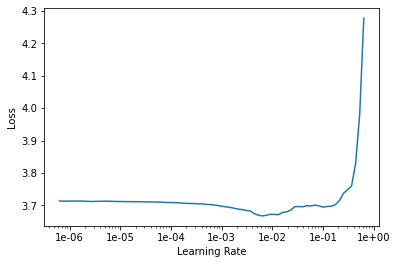

In [25]:
## Fast ai modules finish here, so we switch back to old dataset:
learn.lr_find()
learn.recorder.plot()
valid_dataset.is_fastai = False

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


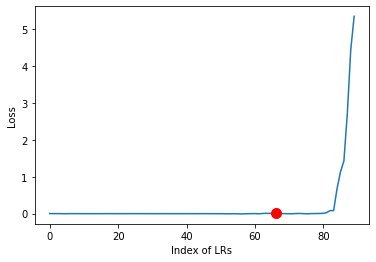

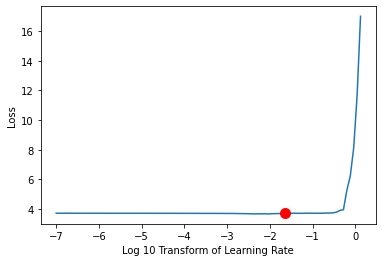

0.022908676527677745


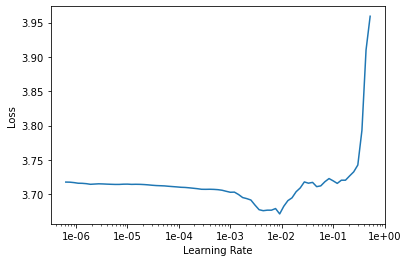

In [26]:
valid_dataset.is_fastai = True
lr = find_appropriate_lr(learn, plot=True)
print(lr)
valid_dataset.is_fastai = False

In [ ]:
"learn.fit(1)"

In [ ]:
#lr=0.005

## Optim and Net learning:

For a **theoretical perspective** of optimization functions, see <cite>Goodfellow, Ian. Deep Learning. Cambridge, Massachusetts, The MIT Press, Publication Date</cite> chapter 8, paragraph 5.
<br>
For the **pytorch documentation** of these functions see [here.](https://pytorch.org/docs/stable/optim.html)<br>
For a brief explication on each optimizer see [here](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/#:~:text=While%20momentum%20accelerates%20our%20search,of%20both%20Momentum%20and%20RMSProp.). **RMSProp vs Adam**, both have adaptive Learning Rates. 
![Optimization evolution figure](Images/optims.jpg)<br>
<center><b>Thanks Paul for the Image!</b></center>

In [20]:
print("Initializing optimizers... \t\t", end="")
# Added momentum:
momentum = 0.9 if use_mixup else 0
    
# InitOptimizers
optimizer_CNN  = InitOptimizer(optimizer_type, CNN_net.parameters(), lr=lr, momentum=momentum)#optim.RMSprop(CNN_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 
optimizer_DNN1 = InitOptimizer(optimizer_type, DNN1_net.parameters(), lr=lr, momentum=momentum)#optim.RMSprop(DNN1_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 
optimizer_DNN2 = InitOptimizer(optimizer_type, DNN2_net.parameters(), lr=lr, momentum=momentum)#optim.RMSprop(DNN2_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 



Initializing optimizers... 		

In [21]:
# Puts the in the same wrapper:
optimizers = Optimizers(optimizer_CNN, optimizer_DNN1, optimizer_DNN2)

print("{} optimizers are ready!".format(optimizer_type))


Adam optimizers are ready!


### Defining schedulers for each optimizers:

The documentation of the scheduler used can be accessed [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau).

In [22]:

## Initializing all schedulers for optims:
scheduler_CNN  = optim.lr_scheduler.ReduceLROnPlateau(optimizer_CNN, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
scheduler_DNN1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_DNN1, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
scheduler_DNN2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_DNN2, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#nbre of training batches per epoch:
#nbre_batch_epoch = snt_tr / batch_size
#step_in_epoch    = 8

#base_lr = max_lr/4 for triangular
#optim.lr_scheduler.CyclicLR(optimizer_CNN, base_lr=0.0001, max_lr=0.001, step_size_up=nbre_batch_epoch*step_in_epoch, step_size_down=None, mode='triangular2', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [23]:
schedulers = Schedulers(scheduler_CNN, scheduler_DNN1, scheduler_DNN2)

### Monitoring the gradient:

This code is taken from a pytorch discussion that you can find [here](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063). 

**Remarks:**

   * We added `and (p.grad is not None)` to each function because some parameters are initialized and named but not learned or used. Therefore their grad is None and has no attribute abs()!
   * It affects parameters like `bn.1.bias`who are initialized but not used in forward and disabled because the config file their are set as so in the config file. We chose to use layernorm instead.

#### Simple function, plots the values:

In [24]:
def plot_grad_flow_simple(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and (p.grad is not None):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

#### More complex functions in order to plot hist:

In [25]:
from matplotlib.lines import Line2D

## Gradient histogram rep, Calot's suggestion:
def plot_grad_flow(named_parameters, plot_both = False):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and (p.grad is not None):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    
    ## Plotting also lines like in plot_grad_flow_simple:
    if(plot_both):
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
    
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    
    


### Confusion Matrix API:

In [26]:
import seaborn as sn
import pandas as pd


## Loaded the list of indexes I already created:
dictOfLabels = np.load("data_lists/labelsToNumberDict.npy").item()

## List of labels
index = [0 for i in range (0, len(dictOfLabels))]

## Putting the label in the right order
for label, i in  dictOfLabels.items():
    index[i] = label

    
def confusion_matrix(mat, qty, pred=None, labels=None, index = index, write_results = False, name = "Test", cuda = True): 
    size = len(index)
    
    if(write_results):
        
        ## Dividing by total number:
        for k in range(size):
            if(qty[k]!= 0):
                mat[k] *= 1/qty[k]
                
        ## Converting mat into data frame in order to use seaborn:
        dataframe = pd.DataFrame(mat, index=index)
        sn.set(font_scale=1)

        # Creates the heatmap:
        fig=plt.figure(figsize=(15, 12), dpi= 400, facecolor='w', edgecolor='k')
        svm = sn.heatmap(dataframe, annot=False)

        # Saves the figure than plots it:
        figure = svm.get_figure()
        figure.savefig('Images/Confusion_Matrices/Conf_Mat_' + name +'.png', dpi=400)
        
        del figure
        #plt.show()
        
    else:
    
        if(pred is None or labels is None):
            print("Error, inputs can't be None if not in write results mode.")
            return -1

        if(mat is None):
            #print("Initialize confusion matrix")
            mat = np.zeros([size,size])
        
        if(qty is None):
            qty = [0]*size
        
        if cuda and (not pred.is_cuda or not labels.is_cuda):
            pred   = pred.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        
        
        for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
         # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
            mat[labels[k].item(),pred[k].item()] +=1
            qty[labels[k].item()]                +=1
            
        
            
    return mat, qty

### Mixup Augmentation:

Credit to Lionel, see original file [here](https://gitlab.tech.orange/lionel.delphinpoulat/dcase2018_task5/-/blob/master/datagenerator.py).<br>
Also, this repos helped, see [here](https://github.com/hysts/pytorch_mixup/blob/master/utils.py).<br>
To convert into one_hot encoded we use `tensor.scatter_(dim, index, src)`. Its documentation is available [here](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.scatter_).<br>

    Brief description :
> Writes all values from the tensor `src` into `self` at the indices specified in the `index` tensor. For each value in `src`, its output index is specified by its index in `src` for `dimension != dim` and by the corresponding value in `index` for `dimension = dim`.

In [27]:
def onehot(label, n_classes):
    return torch.zeros(label.size(0), n_classes).scatter_(
        1, label.view(-1, 1), 1)

def mixup(data, targets, beta_coef, n_classes, sameClasses = False, debug = False):
    if(data.size(0) != targets.size(0)):
        print("The amount of data and labels are not the same !")
        return -1
    
    if(sameClasses):
        indices_by_labels = {}
        
        for i, el in enumerate(targets):
            ## Gets the value in the tensor:
            el = el.item()
            
            if indices_by_labels.get(el) is None:
                indices_by_labels[el] = [i]
            else:
                l = indices_by_labels[el]
                l.append(i)
                indices_by_labels[el] = l
                        
        indices = torch.zeros(targets.size(0), dtype = torch.long)
        
        for key in indices_by_labels.keys():
            
            initial_ids = np.array(indices_by_labels[key])
            
            perm        = np.random.permutation(initial_ids.size)
            
            new_ids     = initial_ids[perm]
            
            indices[torch.from_numpy(initial_ids)] = torch.from_numpy(new_ids)
            
        #print(targets == targets[indices])
        
    else:
        # Creates a random permutation for the data:
        indices = torch.randperm(data.size(0))

        
    # Creates mixed up data:
    data_mix    = data[indices]
    targets_mix = targets[indices]

    # Converts labels into one_hot encoded labels:
    targets     = onehot(targets, n_classes)    
    targets_mix = onehot(targets_mix, n_classes)
    
    # draws the mixup coefficient
    mixup_var = torch.FloatTensor(np.random.beta(beta_coef, beta_coef, data.size(0)))
    
    # Computes the percentage of data that are affected by the mixup:
    mixup_percentage = np.array([i for i in range (data.size(0))]) != np.array([el.item() for el in indices])
    
    for i, el in enumerate(mixup_var):
        mixup_percentage[i] = (mixup_percentage[i] and (el < 0.9999))

    mixup_percentage = sum(mixup_percentage)/data.size(0)
    
    if debug:
        print("mix_var shape %s" % str(mixup_var.shape))
        print("X shape %s" % str(data.shape))
        print("labels %s" % str(targets))
        print("mixup vars :", mixup_var)
        print("Indices :", indices)
        
    # applies mixup to both input data and one-hot encoded labels
    X = torch.rand(data.shape, dtype = torch.float)
    
    for i in range (data.size(0)):
        X[i] = data[i] * mixup_var[i] + data_mix[i] * (1. - mixup_var[i])
        
    y = torch.rand((data.size(0), n_classes), dtype = torch.float)
    
    for i in range (targets.size(0)):    
        y[i] = (targets[i] * mixup_var[i] + targets_mix[i] * (1. - mixup_var[i]))
    
    if debug:
        print("mix label shape %s" % str(y.shape))
        print("%s" % str(y[0]))
    
    return X, y, mixup_percentage


#### Beta density plot:

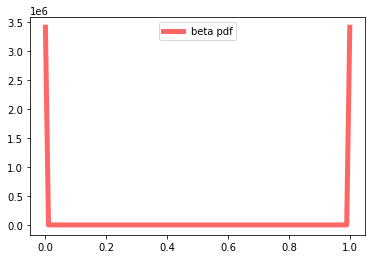

In [28]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = 0.4, 0.4
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

x = np.linspace(beta.ppf(0.00001, a, b),
                beta.ppf(0.99999, a, b), 100)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

plt.legend()
plt.show()

#### Redefining cost function for one hot encoded labels:

In [29]:
## Initializing new cost function:
cost_onehot = NLLL_OneHot()

### Early Stopping:

For a **theoretical perspective**, please refer to <cite>Goodfellow, Ian. Deep Learning. Cambridge, Massachusetts, The MIT Press, Publication Date</cite> chapter 7, paragraph 8, page 240, algorithm $7.1$.<br>


In [30]:
"""
@Batch_dev is the number of test tensors that are stored at once
"""
def accuracy(net, test_loader, criterion, 
             ## SincNet Params
             Batch_dev, wlen, wshift,
             ## Confusion_Matrix param:
             matrix_name, compute_matrix = False,
             cuda=True):
    
    ## Modifs pour SincNet
    net.eval()
    

    loss_sum=0
    err_sum=0
    err_sum_snt=0
    ## End
    
    with torch.no_grad():
        
        # Initializes confusion matrix and quantity to None:
        mat = None
        qty = None
        
        ## Initialisation of storing units for testing:
        stored_outs   = 0
        stored_labels = 0
        stored_idx    = 0
            
        
        ## For SincNet, information in testloader is raw and can be of various lengths!
        for data in test_loader:
            ## Stores data from test_loader:
            audios, labels, file_ids = data
            
            ## Switches to cuda:
            if cuda:
                audios = audios.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            
            
            ## <!> Splits the data by file: time_complexity = O(batch_size) and space_complexity = O(Number_Of_Files)
            section  = []
            ids_list = []
            current_idx = file_ids[0].item()
            ids_list.append(current_idx)
            for i, el in enumerate(file_ids):
                current_el = el.item()
                if current_el != current_idx:
                    current_idx = current_el
                    ids_list.append(current_idx)
                    section.append(i - sum(section))

            ## Last section is added:    
            section.append(audios.size(0) - sum(section))
            #print(section)
            #print(ids_list)

            ## Algorithm that splits the tensors by file:
            X_split = torch.split(audios, section)
            y_split = torch.split(labels, section)

            assert(len(X_split) == len(y_split))
            ## <!> EndSplit <!>

            
            ## Processes file by file the data:
            for i in range(len(X_split)):# nbre_fichier_par_batch= len(X_split)
                ## Stores the current id:
                current_idx    = ids_list[i]
                current_data   = X_split[i] if len(X_split) >= 1 else X_split
                current_labels = y_split[i] if len(y_split) >= 1 else y_split

                if type(stored_outs) is not torch.Tensor:
                    stored_idx    = current_idx
                    stored_outs   = net(current_data)
                    stored_labels = current_labels

                    ## Updates the number of signals
                    #nbr_snt      += 1
                else:

                    if(stored_idx == current_idx):
                        stored_outs   = torch.cat([stored_outs, net(current_data)], dim=0)
                        stored_labels = torch.cat([stored_labels, current_labels], dim=0)

                    else:

                        #pout = stored_outs

                        ## Predicts for every chunk of audio the label and counts how many time it got it correctly
                        pred = torch.max(stored_outs,dim=1)[1]
                        loss = criterion(stored_outs, stored_labels.long())
                        err  = torch.mean((pred!=stored_labels.long()).float())

                        ## Updates the confusion matrix:
                        if(compute_matrix):
                            mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

                        ## Updates the error that I use here:
                        loss_sum=loss_sum+loss.detach()
                        err_sum=err_sum+err.detach()

                        ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
                        [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
                        err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()

                        ## Stores new data:
                        stored_outs   = net(current_data)
                        stored_labels = y_split[i] if len(y_split) >= 1 else y_split
                        stored_idx    = current_idx
        
        ## Last File is not processed by the algorithm above...
        if(stored_outs.size(0) != 0):
            ## Predicts for every chunk of audio the label and counts how many time it got it correctly
            pred = torch.max(stored_outs,dim=1)[1]
            loss = criterion(stored_outs, stored_labels.long())
            err  = torch.mean((pred!=stored_labels.long()).float())

            ## Updates the confusion matrix:
            if(compute_matrix):
                mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

            ## Updates the error that I use here:
            loss_sum=loss_sum+loss.detach()
            err_sum=err_sum+err.detach()

            ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
            [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
            err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()
        
        ## mean Error of best class:
        err_tot_dev_snt=err_sum_snt/snt_te
        
        ## mean Loss:
        loss_tot_dev=loss_sum/snt_te
        
        ## mean Error on each window:
        err_tot_dev=err_sum/snt_te

        ## Plots and saves the confusion matrix:
        if(compute_matrix):
            mat = confusion_matrix(mat, qty, write_results = True, name = matrix_name, cuda = True)
            
            
    net.train()

    return (err_tot_dev_snt, loss_tot_dev, err_tot_dev)

def train(net, optimizer, train_loader, valid_loader, criterion, criterion_onehot,
          ## SincNet variables:
          wlen,
          wshift,
          n_classes,
          ## File variables:
          output_folder,
          fname,
          Models_file_extension,
          ## Hyper param:
          n_epoch = 5,
          patience = 4,
          Batch_dev = 32,#Number of batches for testing set
          train_acc_period = 100,
          test_acc_period = 5,
          ## For mixup:
          beta_coef = 0.5,
          use_mixup = False,
          same_classes = False,
          ## If a Net was loaded:
          starting_epoch = 0,
          ## If user wishes to plot grad:
          plotGrad = False,
          ## If user wishes to use a scheduler:
          use_scheduler = False,
          scheduler = None,
          ## If user wishes to save and compute confusion matrix:
          compute_matrix = False,
          ## Indicates if the network that is trained is SincNet
          is_SincNet = False,
          ## Is Cuda activated?
          cuda=True):
    
    net.train()

    ## Initialization:
    min_loss = float("inf")
    
    ## best_epoch_number is a var that stores the number of epoch required for best performance:
    best_epoch_number = 0
    
    ## p is a counter for how many accuracy checks we made without any improvement on validation loss:
    p=0
    
    ## Declaring to the user that training has begun
    print("Trainining begun with a patience of {} accuracy periods".format(patience), end="")
    if(use_mixup):
        string = ""
        if(same_classes):
            string = "Same Class "
        print(" and using {1}mixup with a Beta({0}, {0}) distribution.".format(beta_coef, string))
    else:
        print(".")
    if use_scheduler:
        print("Training is optimized with a scheduler.")
    print("Total number of classes is equal to : {}".format(n_classes))
    
    ## Continues training beyond n_epoch if algorithm did not converge:
    while(p < patience):
        
        for epoch in tqdm.tqdm(range(starting_epoch + 1, n_epoch + starting_epoch + 1)):  # loop over the dataset multiple times

            ## Stops the training if we exceeded its patience!
            if(p >= patience):
                break


            running_loss = 0.0
            running_acc = 0.0
            running_mixup_percentage = 0.0

            for i, data in enumerate(train_loader, 0):

                # Getting Mixed up data if required by user:
                if(use_mixup):
                    inputs, labels, mixup_states     = data
                    mixup_percentage                 = mixup_states.sum().item() / inputs.size(0)
                    running_mixup_percentage         = 0.33*mixup_percentage + 0.66*running_mixup_percentage
                else:
                    # gets the regular inputs
                    inputs, labels = data
                    
                    

                if cuda:
                    inputs = inputs.type(torch.cuda.FloatTensor)
                    labels = labels.type(torch.cuda.LongTensor)

                # print(inputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)

                ## Loss evaluation:
                    # We use custom made function if there is mixup envolved
                    # Else, we use regular criterion from pytorch
                if(use_mixup):
                    loss = criterion_onehot(outputs, labels.long())
                else:
                    loss = criterion(outputs, labels.long())
                    
                    
                loss.backward()

                ## Plotting the grad for frequencies and second layer 1Dconv:
                if(plotGrad):
                    plot_grad_flow(net.named_parameters())   
                    #plot_grad_flow_simple(net.named_parameters())

                optimizer.step()
                    
                ## If we used mixup, we need to convert back labels to og format.
                if(use_mixup):
                    labels = torch.max(labels, dim = 1)[1]

                running_loss = 0.33*loss.detach() + 0.66*running_loss
                predicted = torch.max(outputs.data, dim = 1)[1]

                ## @correct is the percentage of correct answers by the Net.
                correct = (predicted == labels).sum().item()/labels.size(0)
                running_acc = 0.33*correct + 0.66*running_acc

                # prints statistics during epoch!
                if i % train_acc_period == train_acc_period-1:
                    print("Training set : ")
                    print('[%d, %5d] running loss: %.3f' %(epoch, i + 1, running_loss))
                    print('[%d, %5d] running acc: %.3f' %(epoch, i + 1, running_acc))
                    
                    if use_mixup:
                        print('[%d, %5d] running mixup percentage: %.3f' %(epoch, i + 1, running_mixup_percentage))



            ## Validation loop part:
            if epoch % test_acc_period == 0:
                best_class_error, cur_loss, window_error = accuracy(net, valid_loader, criterion, 
                                                                    Batch_dev, wlen, wshift,
                                                                    matrix_name = fname, compute_matrix = compute_matrix,
                                                                    cuda=cuda)
                
                
                
                ## If user wishes to use a scheduler:
                if(use_scheduler):
                    scheduler.step(cur_loss)


                ## Writing the results in the specified file:
                with open(output_folder+"/" + fname + ".res", "a") as res_file:
                    res_file.write("epoch %i, running_loss_tr=%f running_acc_tr=%f best_class_acc_te=%f loss_te=%f window_acc_te=%f \n" % 
                                                                                                 (epoch,
                                                                                                 running_loss,
                                                                                                 running_acc,
                                                                                                 1-best_class_error,
                                                                                                 cur_loss,
                                                                                                 1-window_error))   

                print("\n")
                print("Validation set : ")
                print('[%d] test loss: %.3f'       %(epoch, cur_loss))
                print('[%d] window acc: %.3f'      %(epoch, 1-window_error))
                print('[%d] best class acc: %.3f'  %(epoch, 1-best_class_error))


                if(cur_loss < min_loss):
                    ## Saves the new loss:
                    min_loss = cur_loss

                    ## Saves the parameters if they are better:
                    # SincNet saving method:
                    if is_SincNet:
                        torch.save(net.CNN_net.state_dict(), output_folder + '/' + fname + "_CNN" + Models_file_extension)
                        torch.save(net.DNN1_net.state_dict(), output_folder+ '/' + fname + "_DNN1" + Models_file_extension)
                        torch.save(net.DNN2_net.state_dict(), output_folder+ '/' + fname + "_DNN2" + Models_file_extension)
                    
                    # Regular save:
                    torch.save(net.state_dict(), output_folder+ '/' + fname + "_Main_net" + Models_file_extension)

                    ## Resets the patience, we found a better net.
                    p = 0

                    ## Stores the best number of epoch:
                    best_epoch_number = epoch

                else:
                    p +=1
        
        ## Inside While scope:
        starting_epoch += n_epoch#Here we go again...


      
    print('Finished Training, the best number of epoch was {}.'.format(best_epoch_number))
    
    # If user wants to plot grad: 
    if(plotGrad):
        ## Saves figure:
        plt.savefig("Images/" + fname + "_GradFlow.png", format = 'png')
        
        ## Then shows the figure:
        plt.show()
        


#### Loading previously trained model if needed:

In [31]:
def LoadPrevModel(model_file_path, Models_file_extension, Load, evalMode = False, inSameFile = True, at_epoch = N_epochs):
    if(Load == False):
        return 0
    
    
    ## Setting the parameters of the previously defined networks 
    global Main_net, CNN_net, DNN1_net, DNN2_net
    
    
    if(inSameFile):
        ## Loading the pretrained setup file
        pretrainedSetup = torch.load(model_file_path + Models_file_extension)
        #print(pretrainedSetup['CNN_model_par'])
        
        ## Loading net parameters one by one:
        CNN_net.load_state_dict(pretrainedSetup['CNN_model_par'])
        if(evalMode):CNN_net.eval()

        DNN1_net.load_state_dict(pretrainedSetup['DNN1_model_par'])
        if(evalMode):DNN1_net.eval()

        DNN2_net.load_state_dict(pretrainedSetup['DNN2_model_par'])
        if(evalMode):DNN2_net.eval()
                    
    else:
        ## Loading all the pretrained setup file
        
        pretrainedSetup_CNN  = torch.load(model_file_path + "_CNN" + Models_file_extension)
        pretrainedSetup_DNN1 = torch.load(model_file_path + "_DNN1" + Models_file_extension)
        pretrainedSetup_DNN2 = torch.load(model_file_path + "_DNN2" + Models_file_extension)
        
        ## Loading net parameters one by one:
        CNN_net.load_state_dict(pretrainedSetup_CNN)
        if(evalMode):CNN_net.eval()

        DNN1_net.load_state_dict(pretrainedSetup_DNN1)
        if(evalMode):DNN1_net.eval()

        DNN2_net.load_state_dict(pretrainedSetup_DNN2)
        if(evalMode):DNN2_net.eval()
    
    
    
    ## Putting all the nets into Main_net:
    Main_net = Main_net = MainNet(CNN_net, DNN1_net, DNN2_net)
    if(evalMode):Main_net.eval()

    
    #print(CNN_net.state_dict()['conv.0.low_hz_'][0])
    
    print("Models from " + model_file_path + " were loaded successfully!")
    
    return at_epoch + 1

In [32]:
## Parameters that needs to change each execution:
Training_model_file   = output_folder.split("/")[-2] if output_folder.split("/")[-1]=="" else output_folder.split("/")[-1]
Training_model_file  += "_Notebook"
Models_file_extension = ".pkl" if pt_file == 'none' else pt_file.split(".")[1]
previous_model_path   = output_folder+ '/' + Training_model_file if pt_file == 'none' else pt_file.split(".")[0]
Load_previous_model   = False if pt_file == 'none' else True
at_epoch              = 0
inTheSameFile         = False
plotGrad              = False
n_classes             = class_lay[-1]#41 for SincNet
same_classes          = same_classes
compute_matrix        = False
is_SincNet            = True


## are in cfg:
#beta_coef=0.4
#use_mixup
#N_eval_epoch = 1
#same_classes = True
#use_scheduler         = True


## Loading previously trained model if needed:
previous_epoch = LoadPrevModel(previous_model_path, 
                               Models_file_extension, 
                               Load= Load_previous_model, 
                               inSameFile = inTheSameFile,
                               at_epoch = at_epoch,
                               evalMode = True)


## Training parameters available in the SincNet_TIMIT.cfg file section [optimization]:
# batch_size
# N_epochs     = 1500
# N_batches    = 800
# N_eval_epoch = 8

## Overwriting N_epochs just bcz flemme:
#N_epochs = 58



#### Training occurs below:

In [ ]:
train(Main_net, optimizers, train_loader, valid_loader, cost, cost_onehot,
          ## SincNet variables:
          wlen,
          wshift,
          n_classes,
          ## File variables:
          output_folder,
          Training_model_file,
          Models_file_extension,
          ## Hyper param:
          n_epoch = N_epochs,
          patience = patience,
          Batch_dev = Batch_dev,#Number of batches for testing set
          train_acc_period = train_acc_period,
          test_acc_period = N_eval_epoch,
          ## For Mixup
          beta_coef = beta_coef,
          use_mixup = use_mixup,
          same_classes = same_classes,
          ## Loaded model params:
          starting_epoch = previous_epoch,
          ## Tracking gradient
          plotGrad = plotGrad,
          ## If user wishes to use scheduler:
          use_scheduler = use_scheduler,
          scheduler = schedulers,
          ## If user wishes to save and compute confusion matrix:
          compute_matrix = compute_matrix,
          ## Indicates if the network that is trained is SincNet
          is_SincNet = is_SincNet,
          cuda=True)


  0%|          | 0/100 [00:00<?, ?it/s]

Trainining begun with a patience of 7 accuracy periods.
Training is optimized with a scheduler.
Total number of classes is equal to : 41
Training set : 
[1,   100] running loss: 2.913
[1,   100] running acc: 0.151
Training set : 
[1,   200] running loss: 2.821
[1,   200] running acc: 0.204


  1%|          | 1/100 [00:28<46:31, 28.20s/it]

Training set : 
[2,   100] running loss: 2.832
[2,   100] running acc: 0.211
Training set : 
[2,   200] running loss: 2.511
[2,   200] running acc: 0.246


  2%|▏         | 2/100 [00:56<46:04, 28.21s/it]

Training set : 
[3,   100] running loss: 2.773
[3,   100] running acc: 0.190
Training set : 
[3,   200] running loss: 2.518
[3,   200] running acc: 0.241


  3%|▎         | 3/100 [01:24<45:39, 28.24s/it]

Training set : 
[4,   100] running loss: 2.601
[4,   100] running acc: 0.213
Training set : 
[4,   200] running loss: 2.570
[4,   200] running acc: 0.271


  4%|▍         | 4/100 [01:53<45:17, 28.31s/it]

Training set : 
[5,   100] running loss: 2.379
[5,   100] running acc: 0.250
Training set : 
[5,   200] running loss: 2.335
[5,   200] running acc: 0.293


Validation set : 
[5] test loss: 2.433
[5] window acc: 0.314
[5] best class acc: 0.373


  5%|▌         | 5/100 [03:48<1:25:55, 54.27s/it]

### Magical Line of code that empties the cache:

In [ ]:
torch.cuda.empty_cache()

## Annexes:

> This part is for unused algorithms that were at some point useful.

### Brut force method:
 We load everything on RAM because we can...

In [ ]:
def load_dataset_on_Ram(data_folder,wav_lst,N_snt,lab_dict, fact_amp, wlen):
    
    # Initialization of the minibatch (batch_size,[0=>x_t,1=>x_t+N,1=>random_samp])
    sig_batch = []
    lab_batch = []
    
    
    rand_amp_arr = np.random.uniform(1.0-fact_amp,1+fact_amp,N_snt)
    
    for i in range(N_snt):
        
        ## Small Hotfix on windows, we do not put the / before the path.
        [signal, fs] = librosa.core.load(data_folder + wav_lst[i], sr=None)
        
        ## Get signal length:
        snt_len = len(signal)
        
        if(snt_len-wlen < 0): 
            raise Exception("error len is too small {0} < {1}".format(snt_len, wlen))
            print("error")
            break
            

        channels = len(signal.shape)
        
        ## Their conversion stereo Mono is not taking the mean, like I did, 
        ## but rather taking the first columns
        if channels == 2:
            print('WARNING: stereo to mono: '+data_folder+wav_lst[i])
            signal = signal[:,0]
            
        snt_beg= 0 if snt_len-wlen-1 in (0, -1) else np.random.randint(snt_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        snt_end=snt_beg+wlen

        
        ## Signal is stored and randomly amplified
        #Time complexity of copy operation is O(fs* wlen/1000)
        #https://wiki.python.org/moin/TimeComplexity
        singal = [el * rand_amp_arr[i] for el in signal.tolist()[snt_beg: snt_end]]
        
        sig_batch.append(signal.tolist()[snt_beg: snt_end])
        lab_batch.append(lab_dict[wav_lst[i]])
        if(i<5):print(len(sig_batch[i]), lab_batch)

        
    
    tensor_x = torch.FloatTensor(sig_batch) # transform to torch tensor
    del sig_batch
    tensor_y = torch.FloatTensor(lab_batch)
    del lab_batch
    

    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    
    return dataset  

In [ ]:
## Loading all the training dataset on RAM, beceause we can with 64 GB of RAM!
train_dataset = load_dataset_on_Ram(data_folder, wav_lst_tr, 5,#len(wav_lst_tr),
                                    lab_dict, 0.2, wlen)
test_dataset  = load_dataset_on_Ram(data_folder, wav_lst_te, 5,#len(wav_lst_te),
                                    lab_dict, 0.2, wlen)
#print(train_dataset[0])

In [ ]:
## Defines the loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader  = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


## Algorithm That was used for new dataset:

In [31]:
criterion = cost

## To remove:
CNN_net.eval()
DNN1_net.eval()
DNN2_net.eval()


## Initialisation before forloop
stored_labels = 0
stored_outs   = 0
stored_idx    = 0

loss_sum    = 0
err_sum     = 0
err_sum_snt = 0


current_idx = 0

nbr_snt = 0

with torch.no_grad():
    for i, data in enumerate(valid_loader):

        if(i >= 7):
            break

        X, labels, tensor_ids = data

        section = []
        ids_list = []
        current_idx = tensor_ids[0].item()
        ids_list.append(current_idx)
        for i, el in enumerate(tensor_ids):
            current_el = el.item()
            if current_el != current_idx:
                current_idx = current_el
                ids_list.append(current_idx)
                section.append(i - sum(section))

        ## Last section is added:    
        section.append(X.size(0) - sum(section))
        print(section)
        print(ids_list)

        ## Algorithm that splits the tensors by file:
        X_split = torch.split(X, section)
        y_split = torch.split(labels, section)

        assert(len(X_split) == len(y_split))

        for i in range(len(X_split)):
            ## Stores the current id:
            current_idx    = ids_list[i]
            current_data   = X_split[i] if len(X_split) >= 1 else X_split
            current_labels = y_split[i] if len(y_split) >= 1 else y_split
            
            ## To delete:
            current_data   = current_data.type(torch.cuda.FloatTensor)
            current_labels = current_labels.type(torch.cuda.LongTensor)
            

            if type(stored_outs) is not torch.Tensor:
                stored_idx    = current_idx
                stored_outs   = DNN2_net(DNN1_net(CNN_net(current_data)))
                stored_labels = current_labels

                ## Updates the number of signals
                nbr_snt      += 1
            else:

                if(stored_idx == current_idx):
                     ## To delete:
                    stored_outs   = stored_outs.type(torch.cuda.FloatTensor)
                    stored_labels = stored_labels.type(torch.cuda.LongTensor)
                    
                    
                    stored_outs   = torch.cat([stored_outs, DNN2_net(DNN1_net(CNN_net(current_data)))], dim=0)
                    stored_labels = torch.cat([stored_labels, current_labels], dim=0)

                else:
                    ## To delete:
                    stored_outs   = stored_outs.type(torch.cuda.FloatTensor)
                    stored_labels = stored_labels.type(torch.cuda.LongTensor)
                    compute_matrix = False
                    ## End to delete--

                    #pout = stored_outs

                    ## Predicts for every chunk of audio the label and counts how many time it got it correctly
                    pred = torch.max(stored_outs,dim=1)[1]
                    loss = criterion(stored_outs, stored_labels.long())
                    err  = torch.mean((pred!=stored_labels.long()).float())

                    ## Updates the confusion matrix:
                    if(compute_matrix):
                        mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

                    ## Updates the error that I use here:
                    loss_sum=loss_sum+loss.detach()
                    err_sum=err_sum+err.detach()

                    ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
                    [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
                    err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()

                    ## Stores new data:
                    stored_outs   = DNN2_net(DNN1_net(CNN_net(current_data)))
                    stored_labels = y_split[i] if len(y_split) >= 1 else y_split
                    stored_idx    = current_idx
                    nbr_snt      += 1



        print(X_split)
        print(current_idx)
        print(loss_sum, err_sum, err_sum_snt)
        print(stored_data.size(0))
    nbr_snt

[12, 20]
[0, 1]
(tensor([[-0.1218, -0.1462, -0.1257,  ..., -0.2727, -0.3080, -0.3364],
        [ 0.1029,  0.0696,  0.0426,  ...,  0.1946,  0.1648,  0.1294],
        [-0.2260, -0.2151, -0.1955,  ..., -0.1181, -0.1349, -0.1238],
        ...,
        [-0.1667, -0.2136, -0.2070,  ...,  0.0901,  0.0955,  0.0840],
        [-0.3293, -0.3412, -0.3814,  ...,  0.3096,  0.3188,  0.3355],
        [ 0.0308, -0.0971, -0.1494,  ..., -0.1729, -0.2203, -0.2404]]), tensor([[-3.1162e-05, -3.3168e-07,  3.2861e-05,  ...,  3.2443e-02,
          1.3248e-02,  1.8848e-03],
        [ 1.4278e-02, -3.9172e-03, -4.4962e-02,  ..., -1.2917e-01,
         -1.3032e-01, -1.3979e-01],
        [-1.6374e-02,  2.6467e-02,  1.7332e-02,  ...,  1.6865e-01,
          1.7071e-01,  1.6238e-01],
        ...,
        [ 3.9253e-02,  2.0674e-02,  3.5646e-02,  ...,  1.5996e-01,
          1.8126e-01,  1.8925e-01],
        [ 2.0677e-02, -1.7662e-01, -1.8921e-01,  ..., -1.0287e-02,
         -6.2360e-02, -8.5594e-02],
        [ 1.7213e-01

### First method used to create Tensors:

In [ ]:
"""
Objective: (will change, I am thinking of putting it with preprocessing functions)
    We want to convert the audio files at @data_folder that are in @wav_lst into tensors and then store them on the Hard disk.
    It will save us some RAM, but also will allow us to have a dataset of tensors with != shapes.

Args:
    @lab_dict     is a dictionary that contains the true labels of the audio files, keys are the file names and values are the label.
    @data_folder  is the path to the folder containing the audio files
    @wav_lst      is the list of audio files to transform into tensors
    @N_snt        is the number of files to transform
    @path_to_save is the path where the tensors need to be written at
"""

## Maybe move it to preprocessing ? Lionel's aproval.
def create_audio_tensors(lab_dict, data_folder, wav_lst, N_snt, path_to_save):
    
    tensors_lst = []
    
    for i in range(N_snt):
        
        current_file_name = wav_lst[i]
        
        [signal, fs] = librosa.core.load(data_folder + current_file_name, sr=None)
        
        temp_t = torch.tensor(signal).float()
        
        new_name = current_file_name.split(".")[0] + ".pt"
        
        tensors_lst.append(new_name)
        
        torch.save(temp_t, path_to_save + new_name)
    
    print("finished writing in the " + path_to_save + " folder!")
    
    return tensors_lst
        

In [ ]:
nbre_of_classes = 41 
b = torch.rand(32,nbre_of_classes, dtype=torch.float)
print(b)

In [ ]:

lab = torch.randint(0, nbre_of_classes, (b.size(0),))
print(lab)

In [ ]:
b.shape

In [ ]:
X, y, mixup_percentage = mixup(b, lab, 0.4, nbre_of_classes, True, True)
print(X)
print(y)
print("The mixup percentage is {}".format(mixup_percentage))

In [ ]:
## Then we take the max of the labels after loss evaluation:

y.max(dim=1)[1]

In [ ]:
## Scatter
#torch.zeros(5, nbre_of_classes).scatter_(1, torch.zeros(5, nbre_of_classes).view(-1, 1).long(), 1)

## Converts lab into onehot manually:
one_hot = torch.zeros(lab.size(0), nbre_of_classes)
for i in range (one_hot.size(0)):
    one_hot[i][lab[i]]=1
one_hot

In [ ]:
onehot(lab, nbre_of_classes)

In [ ]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()


input = X

target = y.max(dim=1)[1]
target_onehot = y
output = loss(m(input), target)
print(m(input))
print(output)
print(cost_onehot(m(input), target_onehot) )


# Assessing trained models:

## Confusion matrix:

In [ ]:
import seaborn as sn
import pandas as pd


## Loaded the list of indexes I already created:
dictOfLabels = np.load("data_lists/labelsToNumberDict.npy").item()

## List of labels
index = [0 for i in range (0, len(dictOfLabels))]

## Putting the label in the right order
for label, i in  dictOfLabels.items():
    index[i] = label
    
print(index)
print(' \n')
print("Number of different labels: {}". format(len(index)))


def confusion_matrix(model, dataloader, SincNetValid = False, size = len(index), name = "Test", cuda = True, index = index): 
    
    model.eval()
    
    ## Iniotializes the confusion matrix:
    mat = np.zeros([size,size])
    total = 0
    corr = 0
    qty = [0]*size
    
    for inputs, labels in dataloader:
        
        if SincNetValid:
            inputs = inputs[0]
        
        if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
         # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
            if(labels[k].item() == predicted[k].item()):
                corr +=1
            mat[labels[k].item(),predicted[k].item()]+=1
            qty[labels[k].item()]+=1
            
    for k in range(size):
        if(qty[k]!= 0):
            mat[k] *= 1/qty[k]
        
    #model.train()
    dataframe = pd.DataFrame(mat, index=index)
    sn.set(font_scale=1)

    fig=plt.figure(figsize=(15, 12), dpi= 400, facecolor='w', edgecolor='k')

    
    svm = sn.heatmap(dataframe, annot=False)
    

    figure = svm.get_figure()
    figure.savefig('Images/Conf_Mat_' + name +'.png', dpi=400)
    plt.show()
    
    ## Added the accuracy:
    percentage = np.array([mat[i, i] for i in range(0, len(mat))]).sum()/mat.sum()
    
    print("The accuracy on this sample is: {}".format(percentage))


In [ ]:
class Net(nn.Module):

    def __init__(self, CNN_net, DNN1_net, DNN2_net):
        super(Net, self).__init__()
        self.CNN_net  = CNN_net
        self.DNN1_net = DNN1_net
        self.DNN2_net = DNN2_net

    def forward(self, x):
        x = self.DNN2_net(self.DNN1_net(self.CNN_net(x)))
        return x

In [ ]:
net = Net(CNN_net, DNN1_net, DNN2_net)
net.cuda()
net.eval()

In [ ]:
confusion_matrix(net, train_loader, SincNetValid = False, name="NTF_Energy_Window1000_p7_class41")